In [1]:
%load_ext autoreload
%autoreload 2

# External imports
import numpy as np
import polars as pl
from sklearn.metrics import classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Normalization
from tensorflow.keras.callbacks import EarlyStopping

# Local imports
from fart.common.constants import (
    OPEN,
    HIGH,
    LOW,
    CLOSE,
    VOLUME,
    TRADE_SIGNAL,
)
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime
from fart.features.trade_signals import TradeSignals
from fart.model.train_test_split import train_test_split
from fart.visualization.plot_confusion_matrix import plot_confusion_matrix

In [2]:
# Load data and calculate technical indicators
df = pl.read_csv("../data/BTC-EUR.csv")
df = parse_timestamp_to_datetime(df)
df = calculate_technical_indicators(df)

# Generate trading signals based on technical indicators
trade_signals = TradeSignals(df)
trade_signals.generate()
trade_signals.optimize()

# Assign processed data to df
df = trade_signals.df

In [3]:
# Keep only relevant columns
df = df.select([
    OPEN,
    HIGH,
    LOW,
    CLOSE,
    VOLUME,
    TRADE_SIGNAL,
])

# Drop NaNs
df = df.drop_nans()

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df)

# Transform all to numpy arrays in order to process them with TensorFlow
X_train, X_test, y_train, y_test = map(
    lambda x: x.to_numpy(),
    [
        X_train,
        X_test,
        y_train,
        y_test,
    ],
)

In [5]:
# Reshape data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Define normalization layer
normalization = Normalization(axis=-1)
normalization.adapt(X_train_reshaped)

# Define input shape
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

# Define sequential model with normalization, LSTM and Dense layers
model = Sequential(
    [
        Input(shape=input_shape),
        normalization,
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(3, activation="softmax"),
    ]
)

# Compile and fit model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9484 - loss: 0.3237 - val_accuracy: 0.9573 - val_loss: 0.2051
Epoch 2/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - accuracy: 0.9585 - loss: 0.2026 - val_accuracy: 0.9573 - val_loss: 0.2052
Epoch 3/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.9565 - loss: 0.2103 - val_accuracy: 0.9573 - val_loss: 0.2056
Epoch 4/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.9559 - loss: 0.2125 - val_accuracy: 0.9573 - val_loss: 0.2057
Epoch 5/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - accuracy: 0.9565 - loss: 0.2097 - val_accuracy: 0.9573 - val_loss: 0.2060
Epoch 6/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step - accuracy: 0.9574 - loss: 0.2062 - val_accuracy: 0.9573 - val_loss: 0.2054


634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     19403
           1       1.00      0.00      0.00       436
           2       1.00      0.00      0.00       436

    accuracy                           0.96     20275
   macro avg       0.99      0.33      0.33     20275
weighted avg       0.96      0.96      0.94     20275



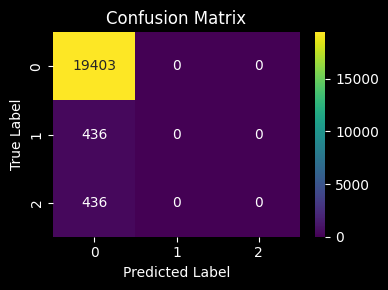

In [6]:
# Reshape test data for prediction
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Predict on test set
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_classes, zero_division=1))
plot_confusion_matrix(y_test, y_pred_classes)